# Evictions in NYC - Explainer notebook

## Table of contents

1. [Motivation](#motivation)
2. [Basic stats](#basicstats) \
    a. [Importing packages](#packages) \
    b. [Data cleaning and preprocessing](#datacleaning) \
    c. [Exploratory data analysis](#exploratory)
3. [Data Analysis](#dataanalysis) \
    a. [Development over the years](#development) \
    b. [Marhals that performed most evictions](#marshals) \
    c. [Boroughs with most evictions](#boroughs) \
    d. [Map with evictions and hotspot areas](#evictionsMap) \
    e. [Insights about housing data](#housing) \
    f. [Insights about economic data](#economic) \
    g. [Insights about demographic data](#demographic) \
    h. [Insights about social data](#social) \
    i. [Interactive map with ACS data](#acsmap)
4. [Genre](#genre)
5. [Visualizations](#visualizations)
6. [Discussion](#discussion)
7. [Contributions](#contributions)
8. [References](#references)

<a id='motivation'></a>
## 1. Motivation

- What is your dataset?
- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?

The main dataset we are using contains the registered evictions performed in New York City from 2017 until today. We decided to analyze this dataset because of our interest in social phenonemena and our excitement to discover patterns, development and connections to other factors. Evictions can be influenced by many elements and we were interested what impact social and economic situations have on this specific topic, as well as rent prices and living conditions. The American Community Survey (ACS) gathers this information with annual elicitations conducted by the U.S. Census Bureau. We are looking at the 5-year-estimates of the latest published years from 2017-2021.
With our analysis we want to provide insights into distribution in NYC and possible correlations between certain factors. The goal is to give an introduction of the topic and let the reader explore the informations further with interacitve plots afterwards.


<a id='basicstats'></a>
## 2. Basic stats

<a id='packages'></a>
### 2a. Importing packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json 
from urllib import request
import plotly.express as px
import plotly.graph_objs as go
import plotly
import os
import seaborn as sns
from functools import reduce
import re
from math import pi
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.transform import cumsum

In [ ]:
# graph settings
%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
output_notebook()

# ignore outputs regarding to missing fonts etc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# create custom color palette
custom_blues = list(sns.cubehelix_palette(start=.5, rot=-.5, n_colors=256, as_cmap=False).as_hex())
custom_blue = custom_blues[100]

plasma_custom = []
cmap = plt.get_cmap('plasma_r', 10)
for i in range(cmap.N):
    rgba = cmap(i)
    plasma_custom += [matplotlib.colors.rgb2hex(rgba)]

<a id='datacleaning'></a>
### 2b. Data cleaning and preprocessing

The dataset was inspected for missing values and we decided to exclude all records from the eviction dataset without an excact geographical location or the Neighborhood Tabulation Area (NTA), since our focus is on displaying these on a map and comparing the NTA's with the ACS data.
- total amount of records in the eviction data: 74593
- after removing all records without a location: 67430

There are some features in the dataset that are not interesting for our analysis so we remove them as well.
- total amount of columns: 20
- after removing uninteresting columns: 15

The ACS data contains one row for each NTA. Until 2020 the number of NTA's was 195, since then it is 262. The amount of feature changes for the year and specific category and ranges from 486 to 2730. We will focus only on a few limited topics that are interesting for our analysis like the average rent price. 

Because the NTA boundaries were changed we are using one json file for the 2010 NTA's and one for the 2020 NTA's. We also investigated if they contain all NTA's mentioned in our datasets.

In [ ]:
# load the eviction dataset
df = pd.read_csv('data/Evictions.csv')

In [ ]:
# turn dates into datetime
df['Executed Date'] = df['Executed Date'].apply(pd.to_datetime)
# add column with just the year
df['year'] = df['Executed Date'].dt.year

In [ ]:
# remove all rows that don't have a specific location
df = df.copy().dropna(subset=['NTA'])
# reomve columns that are not from interest for the analysis
df = df.drop(columns=['Court Index Number', 'Docket Number ','Community Board', 'Council District', 'Census Tract'])

In [117]:
df.isnull().sum()

Eviction Address                0
Eviction Apartment Number    8070
Executed Date                   0
Marshal First Name              0
Marshal Last Name               0
Residential/Commercial          0
BOROUGH                         0
Eviction Postcode               0
Ejectment                       0
Eviction/Legal Possession       0
Latitude                        0
Longitude                       0
BIN                           131
BBL                           131
NTA                             0
year                            0
dtype: int64

In [ ]:
# load data from directories and declare with variable name
myVars = vars()
rootFolder = 'data/'
def load_data(directory, data):
    for filename in os.listdir(rootFolder + directory):
        # filter out hidden files that start with .
        if not filename.startswith('.'):
            # assign following name
            variable_name = "_".join(filename.split("_", 2)[:2])
            data.append(variable_name)
            myVars[variable_name] = pd.read_excel(rootFolder+directory+'/'+filename)
            # add a column with the conducted year
            year = int(variable_name.split("_")[1])
            myVars[variable_name]['year'] = year
            # rename the geoname column to NTA
            myVars[variable_name] = myVars[variable_name].rename(columns={'GeoName': 'NTA', 'GeogName': 'NTA'})
    return data

In [ ]:
# load all of the acs survey data
directories = ['housing_data', 'economic_data', 'social_data', 'demographic_data']
data = []
for directory in directories:
    data = load_data(directory, data)

In [ ]:
# focus only on these columns in the acs data
hous_dict = {'Average Rent': 'MdGRE',
             'Total Housing Units': 'HU1E',
             'GRAPI <15': 'GRPIU15E' , 
             'GRAPI 15-19': 'GRPI15t19E', 
             'GRAPI 20-24': 'GRPI20t24E', 
             'GRAPI 25-29': 'GRPI25t29E', 
             'GRAPI 30-34': 'GRPI30t34E',
             'GRAPI >30': 'GRPI30plE',
             'GRAPI >35': 'GRPI35plE', 
             'GRAPI >50': 'GRPI50plE',
             'year': 'year',
             'NTA': 'NTA',
             'Borough': 'Borough'}

econ_dict = {'Unemployed': 'CvLFUEm1E',
             'Civilian labor force': 'CvLF1E',
             'Average Household Income': 'MnHHIncE',
             'Total Households': 'HH2E',
             'Income below Poverty': 'FamBwPvE', 
             'Industry: Agriculture': 'AgFFHME', 
             'Industry: Construction': 'ConstctnE',
             'Industry: Manufacturing': 'MnfctrngE',
             'Industry: Wholesale trade': 'WhlsaleE',
             'Industry: Retail trade': 'RetailE',
             'Industry: Transportation': 'TrWHUtE',
             'Industry: Information': 'InfoE',
             'Industry: Finance and Insurance': 'FIREE',
             'Industry: Scientific, Management, Administrative Services': 'PrfSMgAWME',
             'Industry: Educational services, Health Care and Social Assistance': 'EdHlthCSAE',
             'Industry: Arts, Entertainment, Accommodation and Food Services': 'ArtEnRAFSE',
             'Industry: Other services': 'OthnotPAE',
             'Industry: Public administration': 'PubAdminE',
             'year': 'year',
             'NTA': 'NTA',
             'Borough': 'Borough'}

soc_dict = {'Family Households': 'Fam1E',
            'Living with Children under 18': 'FamChU18E',
            'Non Family Households': 'NFam1E',
            'Living Alone': 'NFamAE', 
            'Male with Children under 18': 'MHnWChU18E',
            'Female with Children under 18': 'FHnHChU18E',
            'Average Household size': 'AvgHHSzE',
            'College Students': 'SE_ClgGScE',
            'Education: Less than High School': 'EA_LTHSGrE',
            'Education: High School': 'EA_HScGrdE',
            'Education: Bachelor or higher': 'EA_BchDHE',
            'Residence: More than 1 year': 'SmHsE',
            'Residence: Less than 1 year': 'DfHs1E',
            'Native American': 'NtvE',
            'Foreign Born':'Fb1E',
            'year': 'year',
            'NTA': 'NTA',
            'Borough': 'Borough'}

demo_dict = {'Total population': 'Pop_1E',
             'Median Age': 'MdAgeE',
             'Ratio Male': 'MaleE',
             'Ratio Female': 'FemE',
             'Ethnicity: Hispanic/Latino': 'Hsp1E', 
             'Ethnicity: White': 'WtNHE', 
             'Ethnicity: Black or African American': 'BlNHE', 
             'Ethnicity: American Indian and Alaska Native': 'AIANNHE', 
             'Ethnicity: Asian': 'AsnNHE', 
             'Ethnicity: Native Hawaiian and Other Pacific Islander': 'NHPINHE', 
             'Ethnicity: Other race': 'OthNHE', 
             'Ethnicity: Two or more races': 'Rc2plNHE',
             'year': 'year',
             'NTA': 'NTA',
             'Borough': 'Borough'}

acs_dict = hous_dict | econ_dict | soc_dict | demo_dict

# GRAPI = ['GRPIU15E', 'GRPI15t19E', 'GRPI20t24E', 'GRPI25t29E', 'GRPI30t34E', 'GRPI35plE', 'GRPI50plE']

In [ ]:
# reduce the dataframes to only the above selected columns
# create combined dfs for each category

hous_combined = pd.DataFrame()
econ_combined = pd.DataFrame()
soc_combined = pd.DataFrame()
demo_combined = pd.DataFrame()

def reduce_dataframe(frame, columns):
    try:
        myVars[frame] = myVars[frame][columns]
    except Exception as e:
        exceptions = re.findall(r"'(.*?)'", str(e))
        newColumns = [x for x in columns if x not in exceptions]
        myVars[frame] = myVars[frame][newColumns]

for frame in data:
    if frame[:4] == 'hous':
        reduce_dataframe(frame, list(hous_dict.values()))
        hous_combined = pd.concat([hous_combined, myVars[frame]], axis=0)
    elif frame[:4] == 'econ':
        reduce_dataframe(frame, list(econ_dict.values()))
        econ_combined = pd.concat([econ_combined, myVars[frame]], axis=0)
    elif frame[:3] == 'soc':
        reduce_dataframe(frame, list(soc_dict.values()))
        soc_combined = pd.concat([soc_combined, myVars[frame]], axis=0)
    elif frame[:4] == 'demo':
        reduce_dataframe(frame, list(demo_dict.values()))
        demo_combined = pd.concat([demo_combined, myVars[frame]], axis=0)

In [118]:
# load the nta boundaries for 2010 NTA's
with open('NTA_map.geojson') as file:
    nta_json = json.load(file)

for i in list(range(len(nta_json['features']))):
    json_id = nta_json['features'][i]['properties']['ntaname']
    nta_json['features'][i]['id'] = json_id

In [119]:
# load the nta boundaries for 2020 NTA's
url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Neighborhood_Tabulation_Areas_2020/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
with request.urlopen(url) as response:
    nta_json_2020 = json.load(response)

for i in list(range(len(nta_json_2020['features']))):
    json_id = nta_json_2020['features'][i]['properties']['NTAName']
    nta_json_2020['features'][i]['id'] = json_id

In [120]:
# see what NTA's are not in json file
def check_nta_matches(nta_json, data):
    nta_list = []
    for i in list(range(len(nta_json['features']))):
        nta_list += [nta_json['features'][i]['id']]

    missing = 0
    same = 0
    for nta in data['NTA'].unique():
        if nta not in nta_list:
            missing += 1
            print('The following NTA is not in the json file:', nta)
        else: same += 1
    print('Same:',same)
    print('Missing:',missing)

In [121]:
# see if there are NTA geo boundaries missing for the eviction dataset
check_nta_matches(nta_json, df)

Same: 191
Missing: 0


In [122]:
# see if there are 2010 NTA geo boundaries missing for the acs data
check_nta_matches(nta_json, hous_2017)

The following NTA is not in the json file: Hudson Yards-Chelsea-Flat Iron-Union Square
Same: 194
Missing: 1


In [123]:
# see if there are 2020 NTA geo boundaries missing for the acs data
check_nta_matches(nta_json_2020, hous_2019)

Same: 262
Missing: 0


In [124]:
# replace name of NTA in acs survey data with name used in eviction dataset and json file
for file in data:
    myVars[file] = myVars[file].replace('Hudson Yards-Chelsea-Flat Iron-Union Square', 'Hudson Yards-Chelsea-Flatiron-Union Square')

<a id='exploratory'></a>
### 2c. Exploratory data analysis

- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

<a id='dataanalysis'></a>
## 3. Data Analysis

- Describe your data analysis and explain what you've learned about the dataset.
- If relevant, talk about your machine-learning.

<a id='development'></a>
### 3a. Development over the years

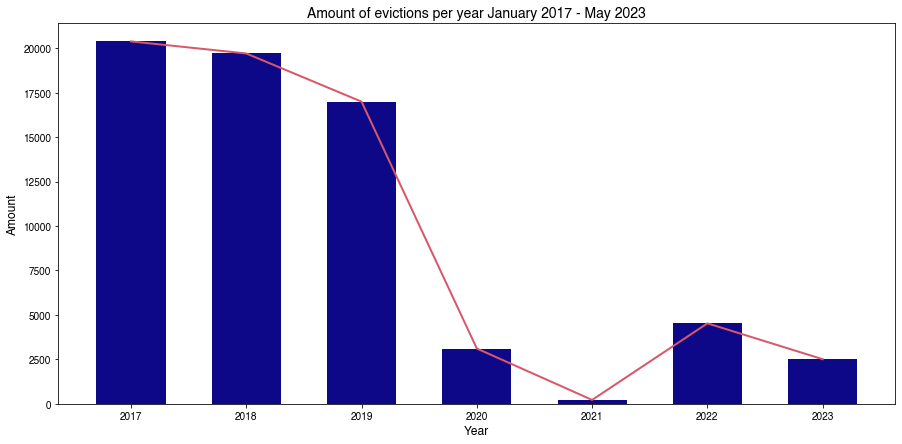

In [125]:
df_years = df.groupby(['year'])['year'].count()
plt.bar(df_years.index, df_years, width=0.6, color=plasma_custom[9])
plt.plot(df_years, color=plasma_custom[4], linewidth=2)
plt.title('Amount of evictions per year January 2017 - May 2023')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.show()

The first plotted histogram depicts the distribution of the number of evictions in the examined period and with a first glimpse, it can easily become evident that COVID-19 has affected dramatically the occurrences. Based on this, a targeted research on articles concerning the Covid period with the performed evictions followed, only to find out, that it was a governmental decision to freeze planned evictions for tenants who had financial problems during that period.

<a id='marshals'></a>
### 3b. Marhals that performed most evictions

In [127]:
df['Marshal Full Name'] = df['Marshal First Name'] + ' ' + df['Marshal Last Name']

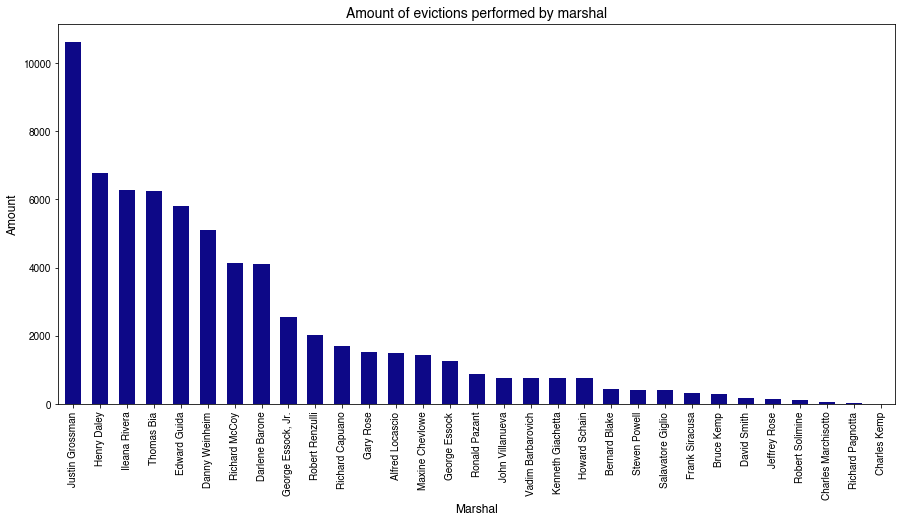

In [129]:
df.groupby(df['Marshal Full Name'])['Executed Date'].count() \
    .sort_values(ascending=False) \
    .plot(kind='bar', color=plasma_custom[9], width=0.6)
plt.title('Amount of evictions performed by marshal')
plt.xlabel('Marshal')
plt.ylabel('Amount')
plt.xticks(rotation=90)
plt.show()

Another interesting information that we derived from the initial dataset is the list of marshals who performed the evictions over the years. The information someone could obtain from this plot is that there is a relatively small number of officers specializing in evictions for such a big city as New York while it is even more interesting to see that a specific police marshal has been in charge for performing most of them.

<a id='boroughs'></a>
### 3c. Boroughs with most evictions

In [ ]:
merge_boroughs = pd.merge(df[['NTA', 'BOROUGH']], hous_2017, left_on=['NTA'], right_on=['NTA'], how='left')
units = merge_boroughs.groupby(['NTA'])['HU1E'].mean().to_frame('units').reset_index()
boroughs = df.groupby(['NTA','BOROUGH'])['BOROUGH'].count().to_frame('amount').reset_index()

boroughs_plot = pd.merge(boroughs, units, left_on=['NTA'], right_on=['NTA'], how='right')    

boroughs_plot = boroughs_plot.groupby(['BOROUGH'])[['amount', 'units']].sum().reset_index()

boroughs_plot['ratio'] = boroughs_plot.amount / boroughs_plot.units
boroughs_plot['angle'] = boroughs_plot.ratio / boroughs_plot.ratio.sum() * (2*pi)
boroughs_plot['z']=110*(boroughs_plot.ratio / boroughs_plot.ratio.sum())
boroughs_plot['color'] = plasma_custom[3:len(df.BOROUGH.unique())+3]

In [130]:
p = figure(plot_height=400, plot_width=650, title="", toolbar_location=None,
           tools="hover", tooltips="@BOROUGH: @z{0.2f} %", x_range=(-.5, .5))

p.annular_wedge(x=0, y=1,  inner_radius=0.15, outer_radius=0.25, direction="anticlock",
                start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='BOROUGH', source=boroughs_plot)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

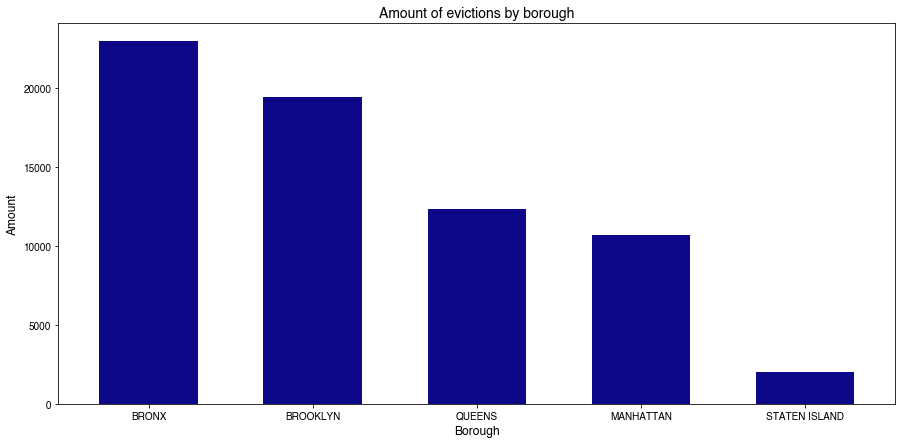

In [132]:
df.groupby(df['BOROUGH'])['Executed Date'].count() \
    .sort_values(ascending=False) \
    .plot(kind='bar', color=plasma_custom[9], width=0.6)
plt.title('Amount of evictions by borough')
plt.xlabel('Borough')
plt.ylabel('Amount')
plt.xticks(rotation=0)
plt.show()

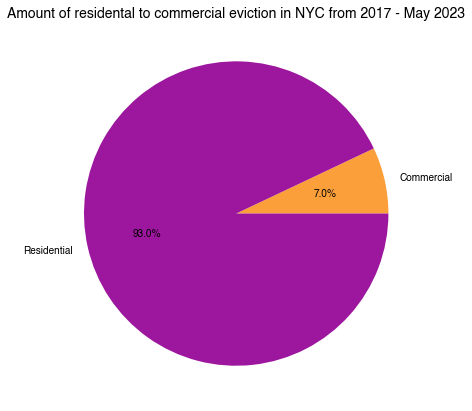

In [154]:
df.groupby(['Residential/Commercial'])['Residential/Commercial'].count().plot.pie(autopct='%1.1f%%', colors=[plasma_custom[2], plasma_custom[6]])
plt.ylabel('')
plt.title('Amount of residental to commercial eviction in NYC from 2017 - May 2023')
plt.show()

From the piechart it can be seen that, the majority of the evictions corresponds to residential buildings with a percentage of 93%. One potential reason is that residential tenants may struggle to pay rent due to financial difficulties or job loss, which can lead to eviction if the landlord is not willing to work out a payment plan or make other accommodations. In contrast, commercial tenants may be companies and firms that have a better financial stability. 

At this point, a distribution of the evictions over the boroughs of NEW YORK was plotted in order to get a first view on the hotspot areas. The borough plot reveals that Bronx stands out with the highest number of recorded evictions followed by BROOKLYN. This information would later be enhanced by plotting the Neighborhood Tabulation Areas (NTAs) in an interactive geo map to investigate further which areas could be considered as eviction "hotspots". Even more, we considered appropriate to search for the rental prices and the annual income in the distinct NTA in order to better interpret and elaborate on our analysis.

<a id='evictionsMap'></a>
### 3d. Map with evictions and hotspot areas

In [ ]:
# prepare data for map
map_data = df.groupby([df.year,'NTA'])['NTA'].count()
map_data = map_data.rename('Evictions').to_frame().reset_index()

In [ ]:
# buildings with the most evictions
df[df['year']==2017].groupby(['BIN'])['BIN'].count().sort_values(ascending=False).iloc[0:5]

The Building Identification Number (BIN) is a unique number each building in NYC. At first glance it seems like the a lot of evictions happened in the building with the number 3000000. But the addresses differ which reveals human noise. However for the buildings where the location is the same it is interesting to investigate further. 

In [ ]:
# closer look shows that this is a storage for example
df[df['BIN']==1080331].iloc[0]['Eviction Apartment Number']

In [ ]:
buildings = df.groupby(['BIN', 'Latitude', 'Longitude', 'year'])['BIN'].count().sort_values(ascending=False).to_frame('amount').reset_index()

In [ ]:
buildings = buildings[buildings.amount > 15]

In [ ]:
fig = px.choropleth_mapbox(map_data, geojson=nta_json, locations='NTA', color='Evictions',
                        color_continuous_scale=custom_blues,
                        mapbox_style="carto-positron",
                        zoom=9.1, center = {"lat": 40.72, "lon": -73.93},
                        animation_frame='year',
                        width=950,
                        height=600,
                        custom_data=['NTA', 'Evictions']
                        )
fig.update_traces(marker_line_width=0.5, 
                  marker_opacity=0.8,
                  hovertemplate='<b>NTA</b>: %{locations}<br>'+'<b>Evictions</b>: %{custom_data[1]}<extra></extra>'
                 )

fig2 = px.scatter_mapbox(buildings, lat="Latitude", lon="Longitude",
            animation_frame = 'year',
            size="amount", 
            color_discrete_sequence = ['black'],
            size_max=7,
            custom_data=['amount']
            )
#fig2.update_traces(hovertemplate='Evictions: %{custom_data[0]}<extra></extra>')

fig.add_trace(fig2.data[0])
for i in range(len(fig.frames)):
    if i >= len(fig2.frames):
        emptydata = fig2.frames[0].data[0]
        emptydata['lat'] = []
        emptydata['lon'] = []
        fig.frames[i].data += (emptydata,)
    else:
        fig.frames[i].data += (fig2.frames[i].data[0],)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
# fig.write_html('evictions-2017-2023-map.html')

The last information derived from our initial dataset is an interactive map of the 195 listed neighborhoods (NTAs) and with the occurences of evictions spanned over the years.

4th plot -> interactive maps of NTAs and evictions (last plot on video )

Analyzing the above, it was judged necessary to incorporate more information about the specified area that could justify or interpret the number of evictions in the examined years. Thus, we searched for economic, social, housing and demographic data of our area and we derived them from the American Community survey website. (dataource here)

<a id='housing'></a>
### 3e. Insights about housing data

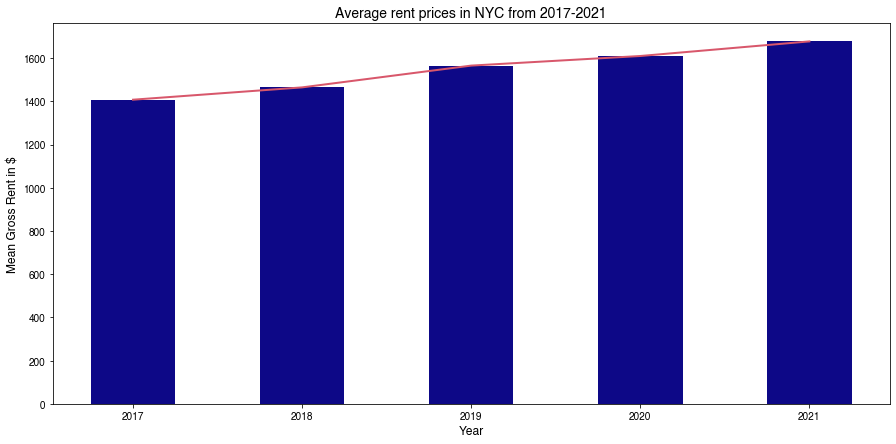

In [133]:
#x_axis = [housing_data.groupby(['year'])['MdGRE'].mean().iloc[0], housing_data.groupby(['year'])['MdGRE'].mean().iloc[1], housing_data.groupby(['year'])['MdGRE'].mean().iloc[2], housing_data.groupby(['year'])['MdGRE'].mean().iloc[3], housing_data.groupby(['year'])['MdGRE'].mean().iloc[4]]
df_rent = hous_combined.groupby(['year'])['MdGRE'].mean()
plt.bar(df_rent.index, df_rent, width=0.5, color=plasma_custom[9])
plt.plot(df_rent, color=plasma_custom[4], linewidth=2)
plt.ylabel('Mean Gross Rent in $')
plt.xlabel('Year')
plt.title('Average rent prices in NYC from 2017-2021')
plt.show()

In [134]:
# average rent 2017
rent2017 = hous_2017['MdGRE'].mean()
rent2021 = hous_2021['MdGRE'].mean()
print(f"Increase of {round(rent2021/rent2017-1, 3)*100}% in average rent from 2017 to 2021")

Increase of 19.2% in average rent from 2017 to 2021


The first thing someone has to search for in order to analyze evictions, is the respective Rent prices as well as the Household income spanned over the examined period. In this regard, we have plotted in the above figure the Mean Gross Rent over the years. It can be seen that Rent prices are steadily increasing over the years, something that does not come along with the decreasing occurences in evictions in the period. For this reason, the mean gross rent should be compared with the respective household income in order to better justify the results.

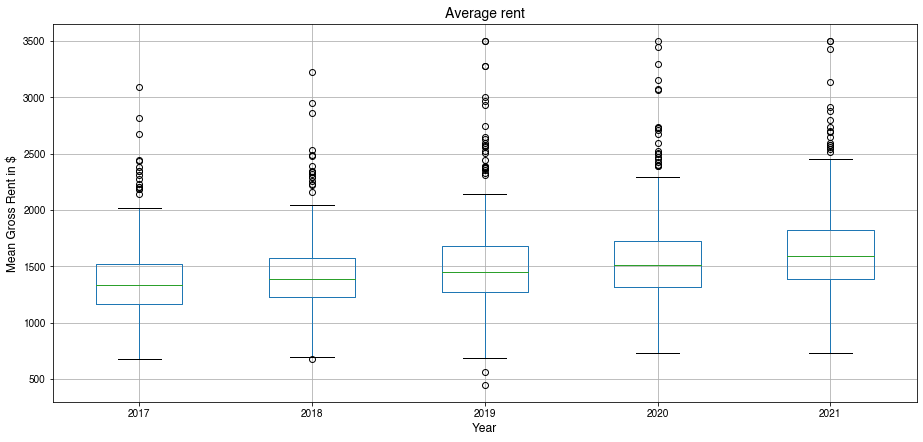

In [135]:
hous_combined.boxplot(column=['MdGRE'], by='year')
plt.xlabel('Year')
plt.ylabel('Mean Gross Rent in $')
plt.title('Average rent')
plt.suptitle('')
plt.show()

Before analyzing the income, it was considered relevant to check also the percentage of the salary that people spend on their rent. At first, a subplot was visualized that contained the necessary information for each of the examined year. It was noticed though, that values were exactly the same for all the years, and thus the above plot illustartes only the year 2021. It can be seen that for the majority of the population, monthly rent accounts for more than 30% of an individual's monthly income, explaining why maybe some are refusing to pay their rent, leading to eviction incidents.

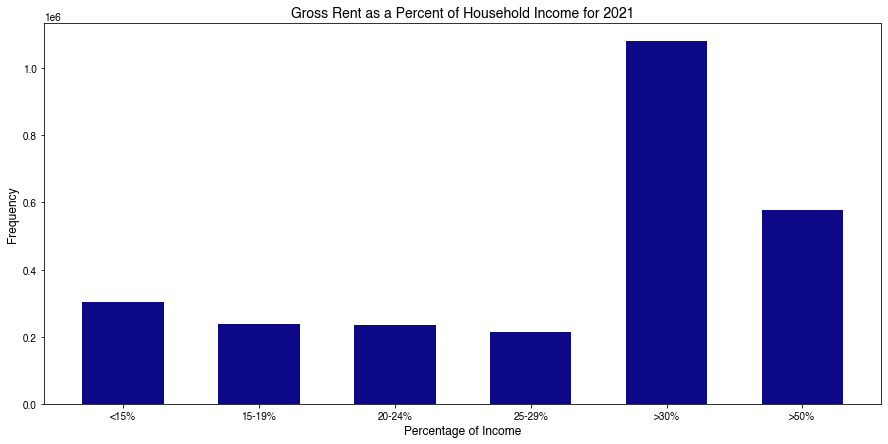

In [136]:
df_GRAPI = hous_2021[['GRPIU15E' , 'GRPI15t19E' , 'GRPI20t24E' , 'GRPI25t29E' , 'GRPI30plE' , 'GRPI50plE']].sum()
plt.bar(df_GRAPI.index, df_GRAPI, width=0.6, color=plasma_custom[9])
plt.xticks(ticks=range(len(df_GRAPI)), labels=['<15%', '15-19%', '20-24%','25-29%','>30%','>50%'])
plt.title('Gross Rent as a Percent of Household Income for 2021')
plt.xlabel('Percentage of Income')
plt.ylabel('Frequency')
plt.show()

Before analyzing the income, it was considered relevant to check also the percentage of the salary that people spend on their rent. The above plot illustrates this information from 2017 to 2021. It can be seen that for all the years, monthly rent accounts for more than 30% of an individual's monthly income, explaining why maybe some are refusing to pay their rent, followed by evictions.

<a id='economic'></a>
### 3f. Insigths about economic data

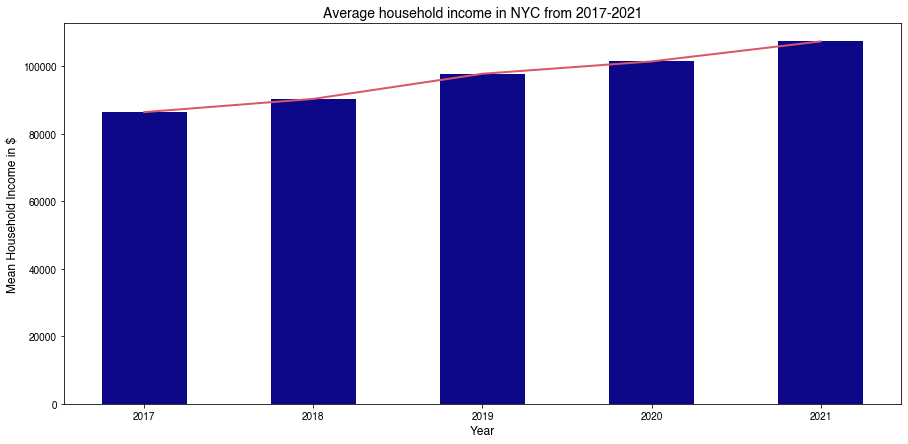

In [137]:
df_income = econ_combined.groupby(['year'])['MnHHIncE'].mean()
plt.bar(df_income.index, df_income, width=0.5, color=plasma_custom[9])
plt.plot(df_income, color=plasma_custom[4], linewidth=2)
plt.ylabel('Mean Household Income in $')
plt.xlabel('Year')
plt.title('Average household income in NYC from 2017-2021')
plt.show()

In our search for the annual household income, we found out that its mean value is increasing over the years. These findings come along with the rent prices that are increasing as well, and they also justify the decreasing occurences in evictions. A reasonable interpretation of the above two plots would be that since the income increases, the rent prices go up and thus a steady economic situation is retained with people paying their rent.

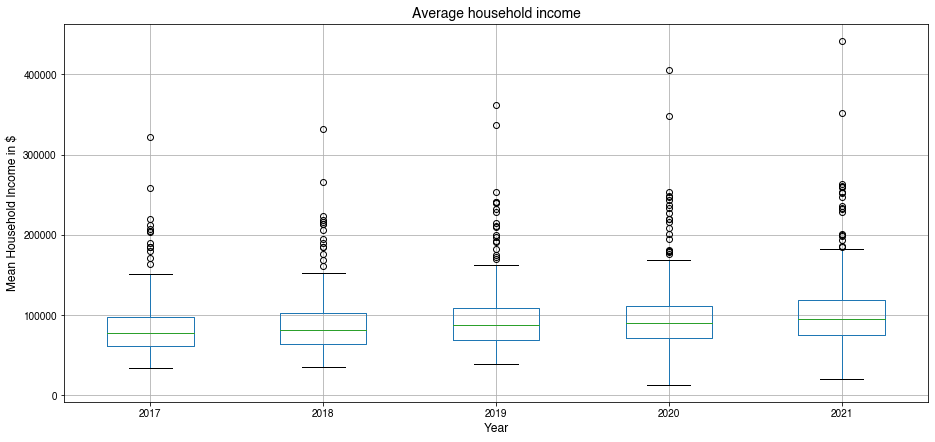

In [138]:
econ_combined.boxplot(column=['MnHHIncE'], by='year')
plt.xlabel('Year')
plt.ylabel('Mean Household Income in $')
plt.title('Average household income')
plt.suptitle('')
plt.show()

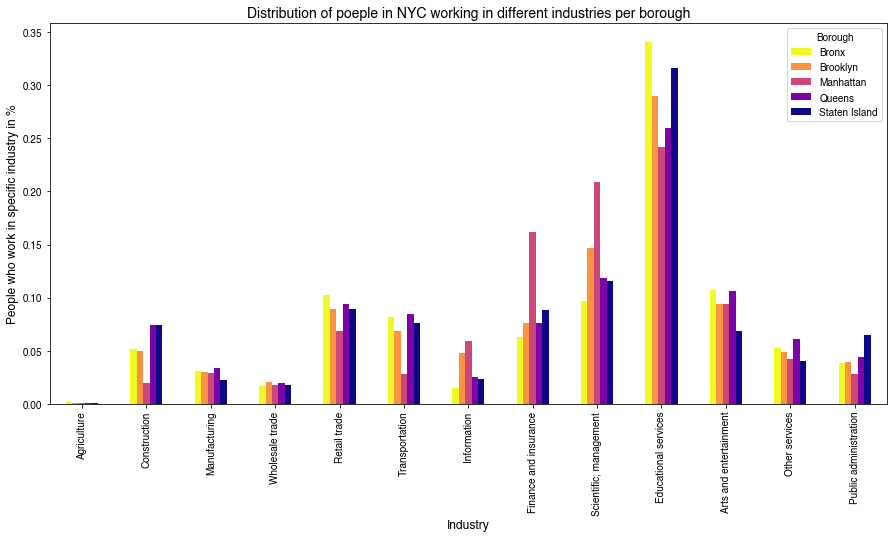

In [172]:
df_industries = econ_2021.groupby(['Borough'])[['AgFFHME', 'ConstctnE','MnfctrngE','WhlsaleE','RetailE','TrWHUtE','InfoE','FIREE','PrfSMgAWME','EdHlthCSAE','ArtEnRAFSE','OthnotPAE','PubAdminE']].sum()
df_industries.rename(columns = {'AgFFHME':'Agriculture', 'ConstctnE':'Construction', 'MnfctrngE':'Manufacturing', 'WhlsaleE':'Wholesale trade', 'RetailE':'Retail trade', 'TrWHUtE':'Transportation', 'InfoE':'Information', 'FIREE':'Finance and insurance','PrfSMgAWME':'Scientific, management','EdHlthCSAE':'Educational services','ArtEnRAFSE':'Arts and entertainment','OthnotPAE':'Other services','PubAdminE':'Public administration'}, inplace = True)
df_industries['sum'] = df_industries.sum(axis=1)
df_industries_ratio = df_industries.div(df_industries['sum'], axis=0)
df_industries_ratio = df_industries_ratio.drop(['sum'], axis=1)

plasma_special = []
cmap = plt.get_cmap('plasma_r', len(df_industries.index))
for i in range(cmap.N):
    rgba = cmap(i)
    plasma_special += [matplotlib.colors.rgb2hex(rgba)]
    
df_industries_ratio.T.plot.bar(color=plasma_special)
plt.xlabel('Industry')
plt.ylabel('People who work in specific industry in %')
plt.title('Distribution of poeple in NYC working in different industries per borough')
plt.show()

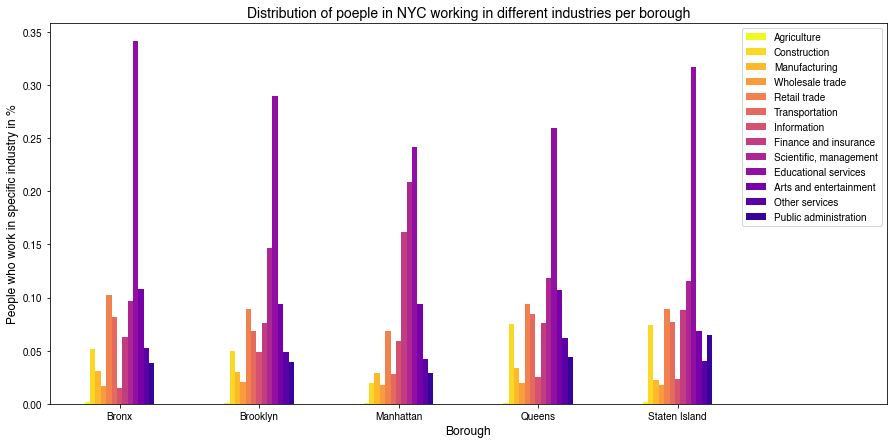

In [179]:
plasma_special = []
cmap = plt.get_cmap('plasma_r', len(df_industries.columns))
for i in range(cmap.N):
    rgba = cmap(i)
    plasma_special += [matplotlib.colors.rgb2hex(rgba)]
    
df_industries_ratio.plot.bar(color=plasma_special)
plt.xlabel('Borough')
plt.ylabel('People who work in specific industry in %')
plt.xticks(rotation=0)
plt.title('Distribution of poeple in NYC working in different industries per borough')
plt.xlim(right=5.5)
plt.show()

Another instersting aspect that can enrich our research on evictions, is the distribution of diferrent professions among the civilian labor force of the city. Thus, we created the above plot that distinguishes the ratio of professions compared to the total population of each borough. It can be seen that Educational services (healthcare, social) is the field in which most people are employed with Bronx standing out with the highest ratio. Moreover, it is clear that Manhattan possesses the highest ratio in Finance and insurance recognized as a financial district worldwide while scientific and management fields are also dominating in Manhattan. Comparing the above with the eviction occurrences among the Boroughs, it can be inferred that the low ratio of evictions in Manhattan can be linked to the fact that a lot of people in this Borough are working in finance which is a highly paid field. 

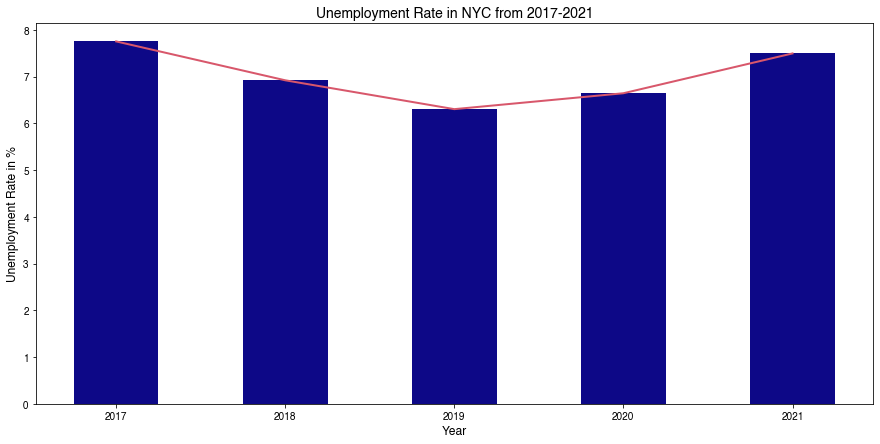

In [139]:
amount_unemployed = econ_combined.groupby(['year'])['CvLFUEm1E'].sum()
amount_labor_force = econ_combined.groupby(['year'])['CvLF1E'].sum()
unemployed_ratio = amount_unemployed / amount_labor_force * 100

plt.bar(unemployed_ratio.index, unemployed_ratio, width=0.5, color=plasma_custom[9])
plt.plot(unemployed_ratio, color=plasma_custom[4], linewidth=2)
plt.xlabel('Year')
plt.ylabel('Unemployment Rate in %')
plt.title('Unemployment Rate in NYC from 2017-2021')
plt.show()

At this point, it makes sense to relate eviction incidents with the unemployment status of the city. In particular, from the supplementary dataset, the total unemployment percentage rate was calculated and plotted against the examined period. It is evident that unemployment in the city of New York is decreasing until 2019, while the outburst of COVID-19 in 2020 boosts the rates. The decrease in unemployment also justifies the downward trend of the evictions in the respective years.

<a id='demographic'></a>
### 3g. Insights about demographic data

Since evictions is a highly controversial phenomenon with many people in favor and against it, we want to check whether there is any correlation with targeted ethnicity groups. For this reason, we retrived information about ethnicity groups in the boroughs of New York and tried to relate it with the corresponding eviction occurrences in these areas.

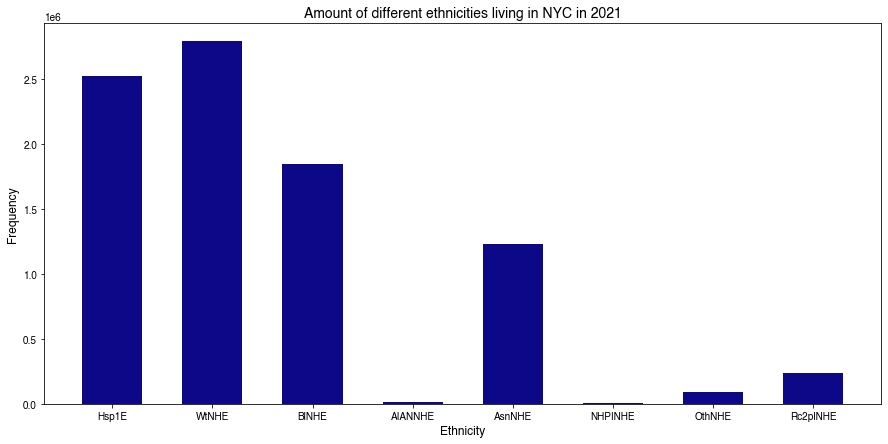

In [140]:
df_ethnicity = demo_2021[["Hsp1E", "WtNHE", "BlNHE", "AIANNHE", "AsnNHE", "NHPINHE", "OthNHE", "Rc2plNHE"]].sum()
plt.bar(df_ethnicity.index, df_ethnicity, width=0.6, color=plasma_custom[9])
plt.title('Amount of different ethnicities living in NYC in 2021')
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')
plt.show()

In the above plot, you can see the distribution of ethnicities in the city of New York. It looks like the majority of the population is White people, Latino and then followed by Black people.

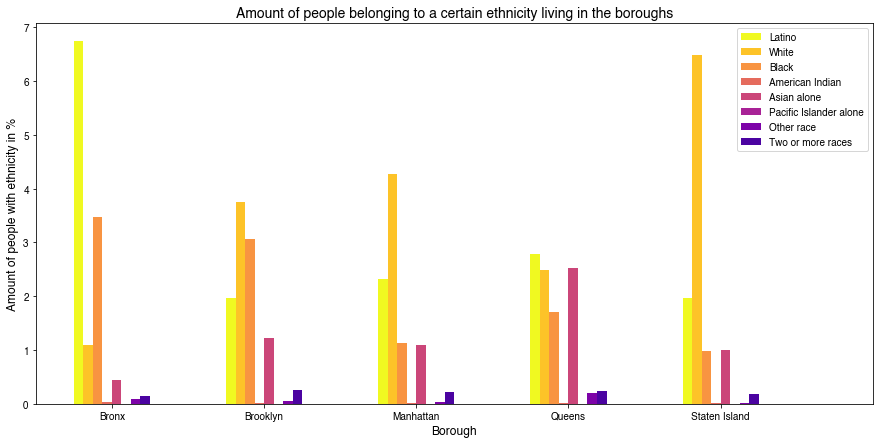

In [182]:
df_ethnicities = demo_combined.groupby("Borough")[["Hsp1E", "WtNHE", "BlNHE", "AIANNHE", "AsnNHE", "NHPINHE", "OthNHE", "Rc2plNHE"]].sum()
df_ethnicities.rename(columns = {'Hsp1E':'Latino', 'WtNHE':'White', 'BlNHE':'Black', 'AIANNHE':'American Indian', 'AsnNHE':'Asian alone', 'NHPINHE':'Pacific Islander alone', 'OthNHE':'Other race', 'Rc2plNHE':'Two or more races'}, inplace = True)

df_ethnicities['sum'] = df_ethnicities.sum(axis=1)
df_ethnicities_ratio = df_ethnicities.div(df_industries['sum'], axis=0)
df_ethnicities_ratio = df_ethnicities_ratio.drop(['sum'], axis=1)

plasma_special = []
cmap = plt.get_cmap('plasma_r', len(df_ethnicities.columns))
for i in range(cmap.N):
    rgba = cmap(i)
    plasma_special += [matplotlib.colors.rgb2hex(rgba)]
    
df_ethnicities_ratio.plot.bar(color=plasma_special)
plt.xlabel('Borough')
plt.ylabel('Amount of people with ethnicity in %')
plt.xticks(rotation=0)
plt.title('Amount of people belonging to a certain ethnicity living in the boroughs')
plt.xlim(right=5)
plt.show()

Based on the above plot, we observe the Bronx Borough is comprised mostly of Latinos and African Americans while White people form the minority of the borough. In contrast, Brooklyn is more or less, evenly distributed among White, Black and Latino ethnicities. Finally, Asian people seem to mostly reside in Queens, while is is evident that Staten Island Borough is mostly comprised of white ethnicities. Trying to correlate ethnicity groups with evictions, it can be noticed that the Bronx borough that has the highest number of evictions, is comprised of Latino and Black people. However, in order to be able to have a clearer and correct assumption on this, more investegation had to follow.

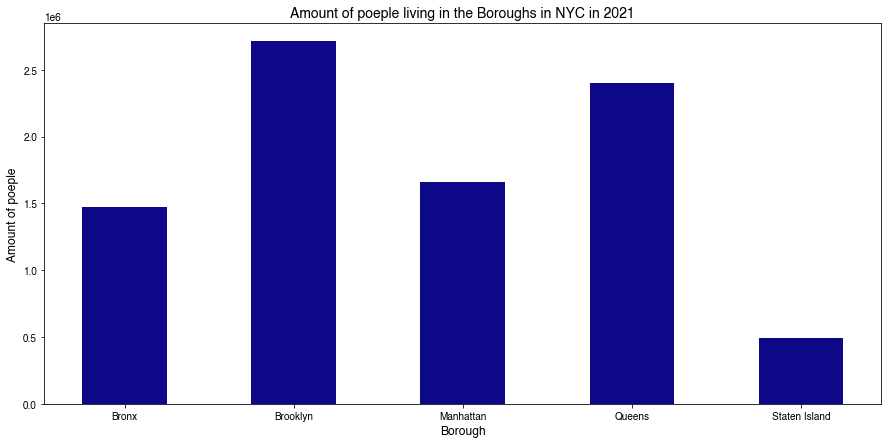

In [141]:
df_borough_pop = demo_2021.groupby("Borough")['Pop_1E'].sum()
plt.bar(df_borough_pop.index, df_borough_pop, width=0.5, color=plasma_custom[9])
plt.xlabel('Borough')
plt.ylabel('Amount of poeple')
plt.title('Amount of poeple living in the Boroughs in NYC in 2021')
plt.show()

From our initial dataset, we identified tha Bronx is the borough with the most evictions. However, in order to be able to better intrepret that information, we decided to plot the respective populations on all the Boroughs. As you can see in the below plot, Brooklyn and Queens are the most populated boroughs while Bronx comes in 4th place. From this results, it makes sense to focus on the Bronx districts and its "characteristics" since the eviction cases are not proportional to the population.

<a id='social'></a>
### 3h. Insights about social data

<a id='acsmap'></a>
### 3i. Interactive map with ACS data

# TODO
- calcualte ration instead of total count for some features
- filter out features with 0

In [ ]:
# merge all acs together
merge = reduce(lambda left,right: pd.merge(left,right,on=['NTA', 'year'],how='outer'), [hous_2017, econ_2017, soc_2017, demo_2017])

In [ ]:
# mapbox_access_token = 'pk.eyJ1IjoiZnJhbnppMTI2IiwiYSI6ImNsZ3NiYnJhdzB2NTQzcG1rdzc0dmo4c2sifQ.8jxznVULScBVloaDu5Xhlw'

fig = go.Figure(go.Choroplethmapbox(
        z=merge['MdGRE'], 
        geojson=nta_json, 
        locations=merge['NTA'],
        #hoverinfo='all',
        text = merge['NTA'],
        hovertemplate = '<b>NTA</b>: <b>%{text}</b>'+'<br><b>Amount</b>: %{z}<br><extra></extra>',
        marker_line_width=0.5, 
        marker_opacity=0.6,
        colorscale=custom_blues))

fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    #title= f'Title',
    autosize=True,
    hovermode='closest',
    showlegend=True,
    #width=950,
    #height=600,
    mapbox=dict(
        #accesstoken=mapbox_access_token,
        bearing=0,
        center={"lat": 40.72, "lon": -73.93},
        pitch=0,
        zoom=9.1,
        style="carto-positron"
        )) 

buttons = []
features = acs_dict.copy()
[features.pop(key) for key in ['year', 'NTA', 'Borough', 'GRAPI >30']]
for k, v in features.items():
    button_dict = {'method': 'update',
                  'label': k,
                  'args': [{'z': [merge[v]]}]}
    buttons.append(button_dict)
    
fig.update_layout(updatemenus=[dict(active=0,
                                    buttons=buttons,
                                    x = 0,
                                    xanchor = 'left',
                                    y = 1.1,
                                    yanchor = 'top',
                                    pad={"r": 10, "t": 10})])

fig.show()

<a id='genre'></a>
## 4. Genre

- Which genre of data story did you use?
- Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
- Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

<a id='visualizations'></a>
## 5. Visualizations

- Explain the visualizations you've chosen.
- Why are they right for the story you want to tell?

<a id='discussion'></a>
## 6. Discussion

- What went well?,
- What is still missing? What could be improved?, Why?

We decided to leave out records with exact geo location which is a total of 67430/74593 = 9,6% of the data. We could improve our analysis by using the provided addresses and a package that can turn these to latitudes and longitudes.

<a id='contributions'></a>
## 7. Contributions

Who did what?

<a id='references'></a>
## 8. References

Evictions https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4

ACS data https://www.nyc.gov/site/planning/planning-level/nyc-population/american-community-survey.page

2010 NTA maps https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz

2020 NTA maps https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page

